## Expert Knowledge Worker

### A question answering agent that is an expert knowledge worker
### To be used by employees of Insurellm, an Insurance Tech company
### The agent needs to be accurate and the solution should be low cost.

This project will use RAG (Retrieval Augmented Generation) to ensure our question/answering assistant has high accuracy.

This first implementation will use a simple, brute-force type of RAG..

In [1]:
# imports

import os
import glob
from dotenv import load_dotenv
import gradio as gr

In [2]:
# imports for langchain, plotly and Chroma

from langchain.document_loaders import DirectoryLoader, TextLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_chroma import Chroma
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import plotly.graph_objects as go
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain
from langchain.embeddings import HuggingFaceEmbeddings

In [18]:
# price is a factor for our company, so we're going to use a low cost model
MODEL = "gemini-2.0-flash"
EMBEDDING_MODEL = "models/gemini-embedding-001"
db_name1 = "vector_db1"
db_name2= "vector_db2"

In [4]:
# Load environment variables in a file called .env

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')

In [5]:
# Read in documents using LangChain's loaders
# Take everything in all the sub-folders of our knowledgebase

folders = glob.glob("knowledge-base/*")

def add_metadata(doc, doc_type):
    doc.metadata["doc_type"] = doc_type
    return doc

# With thanks to CG and Jon R, students on the course, for this fix needed for some users 
text_loader_kwargs = {'encoding': 'utf-8'}
# If that doesn't work, some Windows users might need to uncomment the next line instead
# text_loader_kwargs={'autodetect_encoding': True}

documents = []
for folder in folders:
    doc_type = os.path.basename(folder)
    loader = DirectoryLoader(folder, glob="**/*.md", loader_cls=TextLoader, loader_kwargs=text_loader_kwargs)
    folder_docs = loader.load()
    documents.extend([add_metadata(doc, doc_type) for doc in folder_docs])

text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = text_splitter.split_documents(documents)

print(f"Total number of chunks: {len(chunks)}")
print(f"Document types found: {set(doc.metadata['doc_type'] for doc in documents)}")

Created a chunk of size 1088, which is longer than the specified 1000


Total number of chunks: 123
Document types found: {'contracts', 'products', 'company', 'employees'}


## A sidenote on Embeddings, and "Auto-Encoding LLMs"

We will be mapping each chunk of text into a Vector that represents the meaning of the text, known as an embedding.

OpenAI offers a model to do this, which we will use by calling their API with some LangChain code.

This model is an example of an "Auto-Encoding LLM" which generates an output given a complete input.
It's different to all the other LLMs we've discussed today, which are known as "Auto-Regressive LLMs", and generate future tokens based only on past context.

Another example of an Auto-Encoding LLMs is BERT from Google. In addition to embedding, Auto-encoding LLMs are often used for classification.

### Sidenote

In week 8 we will return to RAG and vector embeddings, and we will use an open-source vector encoder so that the data never leaves our computer - that's an important consideration when building enterprise systems and the data needs to remain internal.

In [23]:
# Put the chunks of data into a Vector Store that associates a Vector Embedding with each chunk
# Chroma is a popular open source Vector Database based on SQLLite

import sys
sys.path.append('/run/media/sijanpaudel/New Volume/New folder/llm_engineering')
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from key_utils import get_next_key
api_key, _ = get_next_key()
print(f"Using API key from Gmail: {_}")

os.environ["GOOGLE_API_KEY"] =api_key
embeddings = GoogleGenerativeAIEmbeddings(model= EMBEDDING_MODEL)
# If you would rather use the free Vector Embeddings from HuggingFace sentence-transformers
# Then replace embeddings = OpenAIEmbeddings()
# with:
# from langchain.embeddings import HuggingFaceEmbeddings
# embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# Delete if already exists

if os.path.exists(db_name1):
    Chroma(persist_directory=db_name1, embedding_function=embeddings).delete_collection()

# Create vectorstore

vectorstore1 = Chroma.from_documents(documents=chunks[:70], embedding=embeddings, persist_directory=db_name1)
print(f"Vectorstore created with {vectorstore1._collection.count()} documents")

Using API key from Gmail: prabeshsubedi
Vectorstore created with 70 documents


In [24]:
vectorstore1

In [25]:
# Put the chunks of data into a Vector Store that associates a Vector Embedding with each chunk
# Chroma is a popular open source Vector Database based on SQLLite

import sys
sys.path.append('/run/media/sijanpaudel/New Volume/New folder/llm_engineering')
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from key_utils import get_next_key
api_key, _ = get_next_key()
print(f"Using API key from Gmail: {_}")

os.environ["GOOGLE_API_KEY"] =api_key
embeddings = GoogleGenerativeAIEmbeddings(model= EMBEDDING_MODEL)
# If you would rather use the free Vector Embeddings from HuggingFace sentence-transformers
# Then replace embeddings = OpenAIEmbeddings()
# with:
# from langchain.embeddings import HuggingFaceEmbeddings
# embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# Delete if already exists

if os.path.exists(db_name2):
    Chroma(persist_directory=db_name2, embedding_function=embeddings).delete_collection()

# Create vectorstore

vectorstore2 = Chroma.from_documents(documents=chunks[70:123], embedding=embeddings, persist_directory=db_name2)
print(f"Vectorstore created with {vectorstore2._collection.count()} documents")

Using API key from Gmail: sandeshtiwari
Vectorstore created with 53 documents


In [26]:
vectorstore2

In [32]:
# --- 2. The Merge Process (CORRECTED) ---
print("\n--- Starting the merge process ---")

# Step A: Get all data (docs, metadata, AND embeddings) from the source vector store.
# This part of the logic was correct and remains the same.
print(f"Extracting data from '{db_name2}'...")
data_from_vec2 = vectorstore2.get(include=["metadatas", "documents", "embeddings"])

source_docs = data_from_vec2['documents']
source_metadatas = data_from_vec2['metadatas']
source_embeddings = data_from_vec2['embeddings']
source_ids = data_from_vec2['ids']

# Step B (THE FIX): Access the underlying Chroma collection and use its native 'add' method.
# The LangChain wrapper stores the native collection in the `_collection` attribute.
print(f"Adding {len(source_docs)} documents directly to '{db_name1}' collection...")
vectorstore1._collection.add(
    embeddings=source_embeddings,
    documents=source_docs,      # Note: the parameter is `documents`
    metadatas=source_metadatas,
    ids=source_ids
)

# --- 3. Verification ---
print("\n--- Verification ---")
final_count = vectorstore1._collection.count()
print(f"Final count in vectorstore1 after merge: {final_count}")


--- Starting the merge process ---
Extracting data from 'vector_db2'...
Adding 53 documents directly to 'vector_db1' collection...

--- Verification ---
Final count in vectorstore1 after merge: 123


In [59]:
import os
from langchain_community.vectorstores import Chroma
from langchain_google_genai import GoogleGenerativeAIEmbeddings

class VectorstoreManager:
    def __init__(self, embedding_model:"models/gemini-embedding-001", db_base_name, chunk_size):
        """
        Args:
            embedding_model (str): The Google Generative AI embedding model to use.
            db_base_name (str): Base name for persistent vectorstore directories.
            chunk_size (int): Number of characters per chunk.
        """
        self.embedding_model = embedding_model
        self.db_base_name = db_base_name
        self.chunk_size = chunk_size
        self.vectorstores = []

        # Calculate batch size based on chunk_size (~4 chars/token, max 20k tokens)
        self.tokens_per_chunk = max(1, self.chunk_size // 4)
        self.chunks_per_batch = max(1, 20000 // self.tokens_per_chunk)
        print(f"Each chunk ~{self.tokens_per_chunk} tokens, max {self.chunks_per_batch} chunks per batch (~20k tokens)")

    def _get_embeddings(self):
        """Get a new embeddings instance using next API key."""
        import sys
        sys.path.append('/run/media/sijanpaudel/New Volume/New folder/llm_engineering')
        from key_utils import get_next_key

        api_key, key_name = get_next_key()
        os.environ["GOOGLE_API_KEY"] = api_key
        print(f"Using API key: {key_name}")
        return GoogleGenerativeAIEmbeddings(model=self.embedding_model)

    def _merge_vectorstores(self, target_store, source_store):
        """Merge source_store into target_store."""
        data = source_store.get(include=["metadatas", "documents", "embeddings"])
        docs, metas, embs, ids = data['documents'], data['metadatas'], data['embeddings'], data['ids']

        print(f"Merging {len(docs)} docs from {source_store._collection.name} into {target_store._collection.name}")
        target_store._collection.add(
            embeddings=embs,
            documents=docs,
            metadatas=metas,
            ids=ids
        )
        return target_store

    def create_vectorstores(self, chunks):
        """
        Split chunks into batches, create vectorstores for each batch using rotating API keys,
        and automatically merge all batches into a single final vectorstore.
        
        Returns:
            Chroma: The final merged vectorstore.
        """
        self.vectorstores = []

        for i in range(0, len(chunks), self.chunks_per_batch):
            batch = chunks[i:i + self.chunks_per_batch]
            db_name = f"{self.db_base_name}_{i // self.chunks_per_batch}"

            embeddings = self._get_embeddings()

            # Delete existing collection if any
            if os.path.exists(db_name):
                Chroma(persist_directory=db_name, embedding_function=embeddings).delete_collection()

            # Create vectorstore
            vs = Chroma.from_documents(documents=batch, embedding=embeddings, persist_directory=db_name)
            print(f"✅ Vectorstore {db_name} created with {vs._collection.count()} documents")
            self.vectorstores.append(vs)

        # Automatically merge all vectorstores into the first one
        final_store = self.vectorstores[0]
        for vs in self.vectorstores[1:]:
            final_store = self._merge_vectorstores(final_store, vs)

        print(f"🎉 Final merged vectorstore has {final_store._collection.count()} documents")
        return final_store


In [60]:
# Initialize manager
manager = VectorstoreManager(embedding_model=EMBEDDING_MODEL, db_base_name="vector_db", chunk_size=1000)

# Create vectorstores and automatically get the merged final store
final_store = manager.create_vectorstores(chunks)


Each chunk ~250 tokens, max 80 chunks per batch (~20k tokens)
Using API key: aayushkafle
✅ Vectorstore vector_db_0 created with 80 documents
Using API key: aasutoshregmi
✅ Vectorstore vector_db_1 created with 43 documents
Merging 43 docs from langchain into langchain
🎉 Final merged vectorstore has 123 documents


In [49]:
final_store

In [15]:
from LLMHandler import LLMHandler
handler = LLMHandler()
handler._patch_retry(enable_retry=True)

In [16]:
for i in range(3):
    key, gmail = get_next_key()
    print(f"Test Gmail: {gmail}", flush=True)

Test Gmail: prabeshsubedi
Test Gmail: sandeshtiwari
Test Gmail: iamengineer


In [50]:
# Let's investigate the vectors

collection = final_store._collection
count = collection.count()

sample_embedding = collection.get(limit=1, include=["embeddings"])["embeddings"][0]
dimensions = len(sample_embedding)
print(f"There are {count:,} vectors with {dimensions:,} dimensions in the vector store")

There are 123 vectors with 3,072 dimensions in the vector store


## Visualizing the Vector Store

Let's take a minute to look at the documents and their embedding vectors to see what's going on.

In [51]:
# Prework (with thanks to Jon R for identifying and fixing a bug in this!)

result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
metadatas = result['metadatas']
doc_types = [metadata['doc_type'] for metadata in metadatas]
colors = [['blue', 'green', 'red', 'orange'][['products', 'employees', 'contracts', 'company'].index(t)] for t in doc_types]

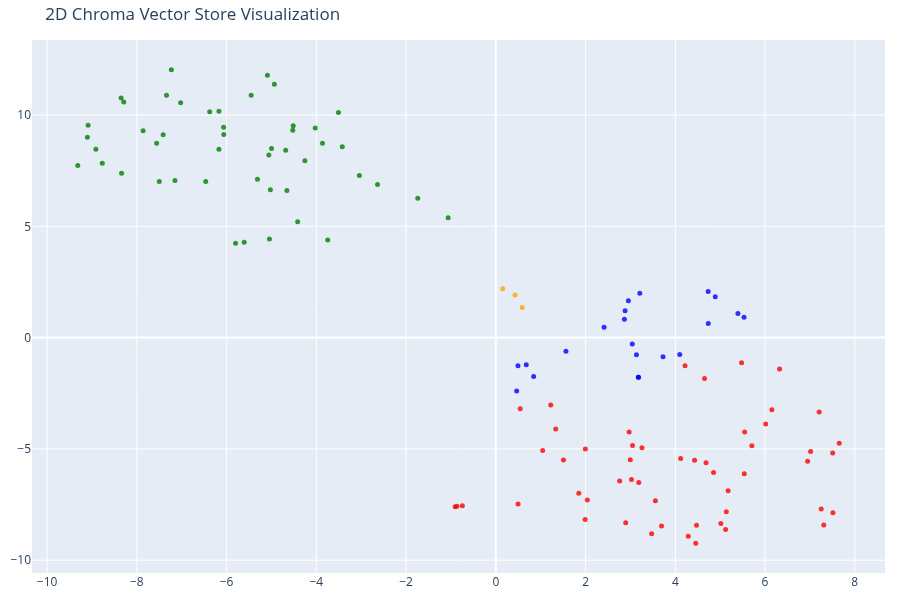

In [52]:
# We humans find it easier to visalize things in 2D!
# Reduce the dimensionality of the vectors to 2D using t-SNE
# (t-distributed stochastic neighbor embedding)

tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Create the 2D scatter plot
fig = go.Figure(data=[go.Scatter(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='2D Chroma Vector Store Visualization',
    scene=dict(xaxis_title='x',yaxis_title='y'),
    width=800,
    height=600,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

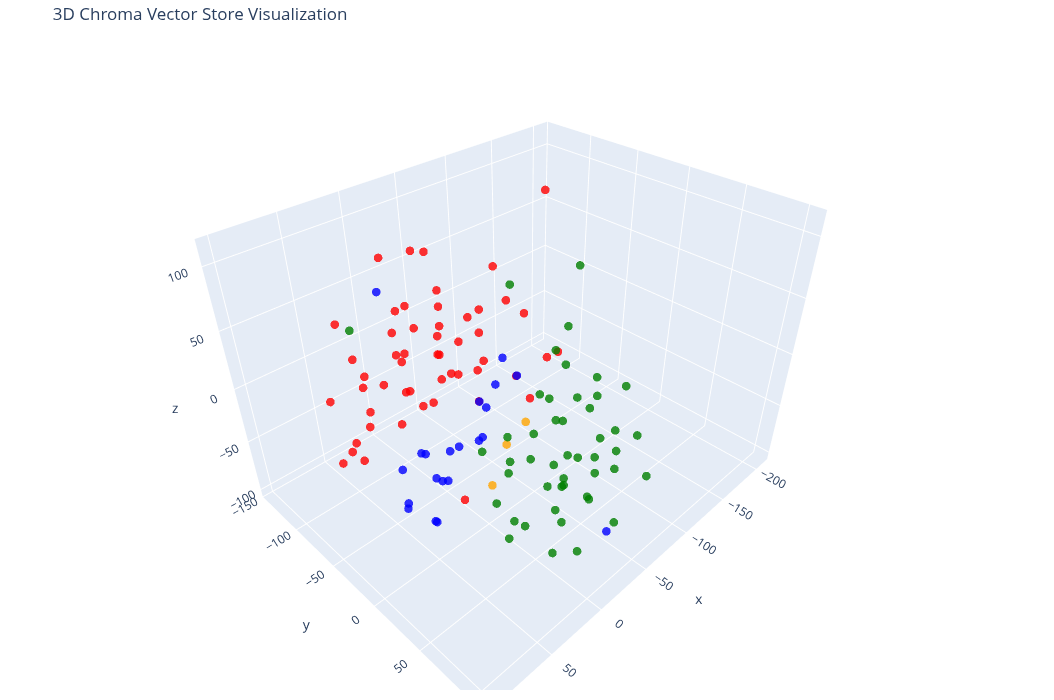

In [53]:
# Let's try 3D!

tsne = TSNE(n_components=3, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    z=reduced_vectors[:, 2],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='3D Chroma Vector Store Visualization',
    scene=dict(xaxis_title='x', yaxis_title='y', zaxis_title='z'),
    width=900,
    height=700,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

## Time to use LangChain to bring it all together

In [61]:
# create a new Chat with OpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(temperature=0.7, model=MODEL)

# Alternative - if you'd like to use Ollama locally, uncomment this line instead
# llm = ChatOpenAI(temperature=0.7, model_name='llama3.2', base_url='http://localhost:11434/v1', api_key='ollama')

# set up the conversation memory for the chat
memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)

# the retriever is an abstraction over the VectorStore that will be used during RAG
retriever = final_store.as_retriever()

# putting it together: set up the conversation chain with the GPT 3.5 LLM, the vector store and memory
conversation_chain = ConversationalRetrievalChain.from_llm(llm=llm, retriever=retriever, memory=memory)

In [62]:
# Let's try a simple question

query = "Please explain what Insurellm is in a couple of sentences"
result = conversation_chain.invoke({"question": query})
print(result["answer"])

Insurellm is an innovative insurance tech firm with 200 employees across the US and more than 300 clients worldwide. They offer 4 insurance software products including Carllm, Homellm, Rellm, and Marketllm.


In [63]:
# set up a new conversation memory for the chat
memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)

# putting it together: set up the conversation chain with the GPT 4o-mini LLM, the vector store and memory
conversation_chain = ConversationalRetrievalChain.from_llm(llm=llm, retriever=retriever, memory=memory)

## Now we will bring this up in Gradio using the Chat interface -

A quick and easy way to prototype a chat with an LLM

In [64]:
# Wrapping that in a function

def chat(question, history):
    result = conversation_chain.invoke({"question": question})
    return result["answer"]

In [65]:
# And in Gradio:

view = gr.ChatInterface(chat, type="messages").launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7874
* To create a public link, set `share=True` in `launch()`.


Opening in existing browser session.


In [34]:
# Let's investigate what gets sent behind the scenes

from langchain_core.callbacks import StdOutCallbackHandler

llm = ChatGoogleGenerativeAI(temperature=0.7, model=MODEL)

memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)

retriever = vectorstore.as_retriever()

conversation_chain = ConversationalRetrievalChain.from_llm(llm=llm, retriever=retriever, memory=memory, callbacks=[StdOutCallbackHandler()])

query = "Who received the prestigious IIOTY award in 2023?"
result = conversation_chain.invoke({"question": query})
answer = result["answer"]
print("\nAnswer:", answer)



> Entering new ConversationalRetrievalChain chain...


> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
System: Use the following pieces of context to answer the user's question.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
----------------
## Insurellm Career Progression
- **January 2017 - October 2018**: **Junior Data Engineer**  
  * Maxine joined Insurellm as a Junior Data Engineer, focusing primarily on ETL processes and data integration tasks. She quickly learned Insurellm's data architecture, collaborating with other team members to streamline data workflows.  
- **November 2018 - December 2020**: **Data Engineer**  
  * In her new role, Maxine expanded her responsibilities to include designing comprehensive data models and improving data quality measures. Though she excelled in technical skills, communication issues with non-technical teams led to some project delays.  
- **J

In [35]:
# create a new Chat with OpenAI
llm = ChatGoogleGenerativeAI(temperature=0.7, model=MODEL)

# set up the conversation memory for the chat
memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)

# the retriever is an abstraction over the VectorStore that will be used during RAG; k is how many chunks to use
retriever = vectorstore.as_retriever(search_kwargs={"k": 25})

# putting it together: set up the conversation chain with the GPT 3.5 LLM, the vector store and memory
conversation_chain = ConversationalRetrievalChain.from_llm(llm=llm, retriever=retriever, memory=memory)

In [36]:
def chat(question, history):
    result = conversation_chain.invoke({"question": question})
    return result["answer"]

In [37]:
view = gr.ChatInterface(chat, type="messages").launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7876
* To create a public link, set `share=True` in `launch()`.


Opening in existing browser session.


# Exercises

Try applying this to your own folder of data, so that you create a personal knowledge worker, an expert on your own information!